In [1]:
import numpy as np
from keras.models import Sequential
import keras.backend as K
from keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D, ZeroPadding2D
from keras.layers.normalization import BatchNormalization
from PIL import Image
import random
import math
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
training_data = np.load('./output/training_data.npy')
training_labels = np.load('./output/training_dists.npy')

#pad the training data matrix so it is 100x1024

#(500, 100, 1000, 1)

# zero_padding_array = np.zeros((500,100,600,1))

In [3]:
BRANCH_NUM = 100
SEQUENCE_LEN = 1000

OUTPUT_DIST_NUM = int((BRANCH_NUM + 1) * BRANCH_NUM / 2)

In [4]:
training_data.shape

(500, 100, 1000, 1)

In [5]:
training_labels.shape

(500, 5050)

In [6]:
# zero_padding_array.shape

In [7]:
# print(training_data.shape)
# training_data = np.concatenate([training_data, zero_padding_array], axis=2)
print(training_data.shape)

print(training_labels.shape)

samples_count = training_data.shape[0]

train_size = math.floor(0.85*training_data.shape[0])

shuffle_indices = random.sample(range(0, samples_count), samples_count)

indices_train = shuffle_indices[0:train_size]
indices_test = shuffle_indices[train_size:samples_count]

X_train = training_data[indices_train,:]
Y_train = training_labels[indices_train]

X_test = training_data[indices_test,:]
Y_test = training_labels[indices_test]

print('X_train.shape : ', X_train.shape)
print('X_test.shape : ', X_test.shape)

print('Y_train.shape : ', Y_train.shape)
print('Y_test.shape : ', Y_test.shape)

np.save('./output/X_test.npy', X_test)
np.save('./output/Y_test.npy', Y_test)


(500, 100, 1000, 1)
(500, 5050)
X_train.shape :  (425, 100, 1000, 1)
X_test.shape :  (75, 100, 1000, 1)
Y_train.shape :  (425, 5050)
Y_test.shape :  (75, 5050)


In [8]:
# model = Sequential()

# # Layer 1
# model.add(Conv2D(64, input_shape=X_train.shape[1:], kernel_size=(3,3), strides=(1,1), padding='same'))
# #model.add(Conv2D(48, input_shape=(400,11,1), kernel_size=(2,2), strides=(1,1), padding='same'))
# model.add(BatchNormalization())
# model.add(Activation('relu'))
# # model.add(MaxPooling2D(pool_size=(1, 2)))

# # Layer 2
# model.add(Conv2D(32, (3,3), padding='same'))
# model.add(BatchNormalization())
# model.add(Activation('relu'))
# # model.add(MaxPooling2D(pool_size=(1, 2)))

# # Layer 3
# model.add(Conv2D(16, (3,3), padding='same'))
# model.add(BatchNormalization())
# model.add(Activation('relu'))
# # model.add(MaxPooling2D(pool_size=(1, 2)))

# # Layer 4
# model.add(Conv2D(1, (2, 1), padding='same'))
# model.add(BatchNormalization())
# model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size=(1, 2)))


In [9]:
model = Sequential()

# Layer 1
model.add(Conv2D(10, input_shape=X_train.shape[1:], kernel_size=(3,3), strides=(1,1)))
#model.add(Conv2D(48, input_shape=(400,11,1), kernel_size=(2,2), strides=(1,1), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Layer 2
model.add(Conv2D(5, (3,3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Layer 3
model.add(Conv2D(5, (3,3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Layer 4
model.add(Conv2D(1, (3,3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Layer 5
model.add(Flatten())
model.add(Dense(OUTPUT_DIST_NUM, activation='relu'))

In [10]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 98, 998, 10)       100       
_________________________________________________________________
batch_normalization_1 (Batch (None, 98, 998, 10)       40        
_________________________________________________________________
activation_1 (Activation)    (None, 98, 998, 10)       0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 49, 499, 10)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 47, 497, 5)        455       
_________________________________________________________________
batch_normalization_2 (Batch (None, 47, 497, 5)        20        
_________________________________________________________________
activation_2 (Activation)    (None, 47, 497, 5)       

In [11]:
def dice_coef(y_true, y_pred, smooth, thresh):
    y_pred = y_pred > thresh
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)

    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

In [12]:
def dice_loss(smooth, thresh):
    def dice(y_true, y_pred):
        return -dice_coef(y_true, y_pred, smooth, thresh)
    return dice

In [15]:
# (4) Compile 
#model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
model.compile(loss=dice_loss(smooth=1e-5, thresh=0.5), optimizer='adam', metrics=['accuracy'])

TypeError: Input 'y' of 'Mul' Op has type bool that does not match type float32 of argument 'x'.

In [97]:
# (5) Train
history = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), batch_size=16, epochs=1, verbose=1)

model.save('./output/CNN_model_03.h5')

Train on 425 samples, validate on 75 samples
Epoch 1/1
425/425 [==============================] - 10s 23ms/step - loss: nan - accuracy: 0.0000e+00 - val_loss: nan - val_accuracy: 0.0000e+00


In [79]:
train_result = model.evaluate(X_train, Y_train)
test_result = model.evaluate(X_test, Y_test)
print("Train Acc: ", train_result)
print("Test Acc: ", test_result)

75/75 [==============================] - 0s 5ms/step
Train Acc:  [nan, 0.0]
Test Acc:  [nan, 0.0]


## X_train plot

In [80]:
X_train_results = model.predict(X_train)

In [81]:
train_show_index = 6

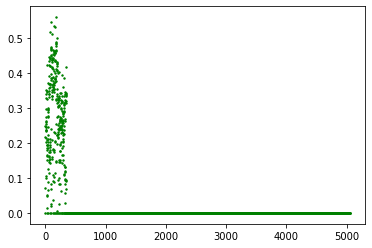

In [82]:
plt.scatter(range(X_train_results[train_show_index].shape[0]), X_train_results[train_show_index], c='r', s = 2)
plt.scatter(range(Y_train[train_show_index].shape[0]), Y_train[train_show_index], c='g', s = 2)

## X_test plot

In [20]:
X_test_results = model.predict(X_test)

In [21]:
test_show_index = 7

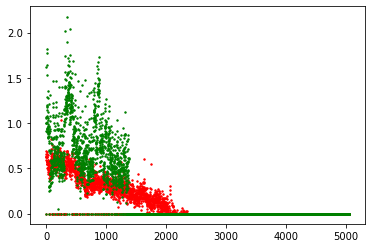

In [22]:
plt.scatter(range(X_test_results[test_show_index].shape[0]), X_test_results[test_show_index], c='r', s = 2)
plt.scatter(range(Y_test[test_show_index].shape[0]), Y_test[test_show_index], c='g', s = 2)

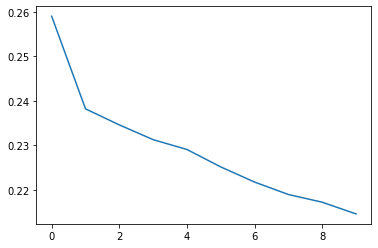

In [23]:
plt.plot(history.history['loss'])
plt.show()